In [71]:
'''This script demonstrates how to build a variational autoencoder with Keras.

'''
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist, cifar10
from keras.optimizers import Adam, SGD
from lib import *

batch_size = 16
original_dim = 3072
latent_dim = 2
# intermediate_dim = 128
intermediate_dim = 256
epsilon_std = 0.01
nb_epoch = 50
lam = 1e-3
learning_rate = 0.01

# train the autoencoder on CIFAR digits
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# flatten image
X_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
X_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

def gen_autoencoder(x_train, x_test, cae=True, vae=False):
    M, N = x_train.shape
    if vae:
        ## vae
        x = Input(batch_shape=(batch_size, original_dim))
        h = Dense(intermediate_dim, activation='relu')(x)
        z_mean = Dense(latent_dim)(h)
        z_log_std = Dense(latent_dim)(h)

        def sampling(args):
            z_mean, z_log_std = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                      mean=0., std=epsilon_std)
            return z_mean + K.exp(z_log_std) * epsilon

        # note that "output_shape" isn't necessary with the TensorFlow backend
        # so you could write `Lambda(sampling)([z_mean, z_log_std])`
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_std])

        # we instantiate these layers separately so as to reuse them later
        decoder_h = Dense(intermediate_dim, activation='relu')
        decoder_mean = Dense(original_dim, activation='sigmoid')
        h_decoded = decoder_h(z)
        x_decoded_mean = decoder_mean(h_decoded)

        def vae_loss(x, x_decoded_mean):
            xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_std - K.square(z_mean) - K.exp(z_log_std), axis=-1)
            return xent_loss + kl_loss
        encoder = Model(x, z_mean)
        autoencoder = Model(x, x_decoded_mean)
        autoencoder.compile(optimizer='rmsprop', loss=vae_loss)
    
    elif cae:

        N_hidden = 64
        N_batch = 100

        inputs = Input(shape=(N,))
        encoded = Dense(N_hidden, activation='sigmoid', name='encoded')(inputs)
        outputs = Dense(N, activation='linear')(encoded)

        autoencoder = Model(input=inputs, output=outputs)
        encoder = Model(input=inputs, output=encoded)
        def contractive_loss(y_pred, y_true):
            mse = K.mean(K.square(y_true - y_pred), axis=1)

            W = K.variable(value=model.get_layer('encoded').get_weights()[0])  # N x N_hidden
            W = K.transpose(W)  # N_hidden x N
            h = model.get_layer('encoded').output
            dh = h * (1 - h)  # N_batch x N_hidden
            # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
            contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)
            
            return mse + contractive

        autoencoder.compile(optimizer='adam', loss=contractive_loss)


    %time his = autoencoder.fit(x_train, x_train, \
            nb_epoch=nb_epoch, \
            batch_size=batch_size, \
            validation_data=(x_test, x_test))
    return his, autoencoder, encoder


In [76]:
THEANO_FLAGS='exception_verbosity=high' 
his, model, encoder = gen_autoencoder(x_train=X_train, x_test=X_test, cae=True, vae=False)

MissingInputError: An input of the graph, used to compute dot(input_39, HostFromGpu.0), was not provided and not given a value.Use the Theano flag exception_verbosity='high',for more information on this error.

Backtrace when the variable is created:
  File "/home/admin0/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/admin0/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/admin0/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/admin0/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-3a6d3fdc7897>", line 74, in <module>
    inputs = Input(shape=(N,))
  File "/home/admin0/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 1075, in Input
    input_tensor=tensor)
  File "/home/admin0/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 993, in __init__
    name=self.name)
  File "/home/admin0/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py", line 85, in placeholder
    x = T.TensorType(dtype, broadcast)(name)


In [ ]:
plot_validation_history(his, './output/cantractive_autoencoder_3_epoch')

In [50]:
def plot_reconstructed_imgs(autoencoder):
    # encode and decode some digits
    # note that we take them from the *test* set
    # encoded_imgs = encoder.predict(x_test)
    # decoded_imgs = decoder.predict(encoded_imgs)
    reconstructed_test_imgs = model.predict(x_test)
    import matplotlib.pyplot as plt

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_test_imgs[i].reshape(28, 28))
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_reconstructed_imgs(model)

ValueError: total size of new array must be unchanged

In [ ]:
'''This script demonstrates how to build a contrative autoencoder with Keras.

'''
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist, cifar10
from lib import *

batch_size = 16
original_dim = 784
latent_dim = 2
intermediate_dim = 128
epsilon_std = 0.01
nb_epoch = 200
lam = 1e-3

# train the autoencoder on CIFAR digits
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# flatten image
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


M, N = x_train.shape
N_hidden = 64
N_batch = 100

inputs = Input(shape=(N,))
encoded = Dense(N_hidden, activation='sigmoid', name='encoded')(inputs)
outputs = Dense(N, activation='linear')(encoded)

model = Model(input=inputs, output=outputs)

def contractive_loss(y_pred, y_true):
    mse = K.mean(K.square(y_true - y_pred), axis=1)

    W = K.variable(value=model.get_layer('encoded').get_weights()[0])  # N x N_hidden
    W = K.transpose(W)  # N_hidden x N
    h = model.get_layer('encoded').output
    dh = h * (1 - h)  # N_batch x N_hidden
    # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
    contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

    return mse + contractive

model.compile(optimizer='adam', loss=contractive_loss)
his=model.fit(x_train, x_train, batch_size=N_batch, nb_epoch=nb_epoch, validation_split=0.2)

#### end of CAE

Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 0s - loss: 0.0573 - val_loss: 0.0418
Epoch 2/200
40000/40000 [==============================] - 0s - loss: 0.0350 - val_loss: 0.0290
Epoch 3/200
40000/40000 [==============================] - 0s - loss: 0.0261 - val_loss: 0.0229
Epoch 4/200
40000/40000 [==============================] - 0s - loss: 0.0218 - val_loss: 0.0203
Epoch 5/200
40000/40000 [==============================] - 0s - loss: 0.0197 - val_loss: 0.0187
Epoch 6/200
40000/40000 [==============================] - 0s - loss: 0.0185 - val_loss: 0.0180
Epoch 7/200
40000/40000 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0170
Epoch 8/200
40000/40000 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0168
Epoch 9/200
40000/40000 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0164
Epoch 10/200
40000/40000 [==============================] - 0s - loss: 0.0164 - val_lo

In [18]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train.shape

(50000, 3072)

In [52]:
from scipy.misc import toimage
def plot_reconstructed_imgs(autoencoder):
    # encode and decode some digits
    # note that we take them from the *test* set
    # encoded_imgs = encoder.predict(x_test)
    # decoded_imgs = decoder.predict(encoded_imgs)
    reconstructed_test_imgs = model.predict(x_test)
    import matplotlib.pyplot as plt

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(toimage(x_test[i].reshape(3, 32, 32)))
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(toimage(reconstructed_test_imgs[i].reshape(3, 32, 32)))
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

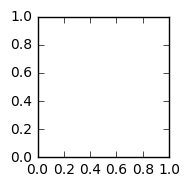

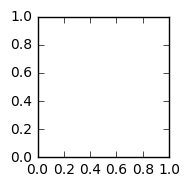

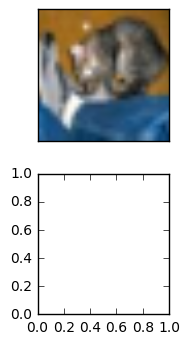

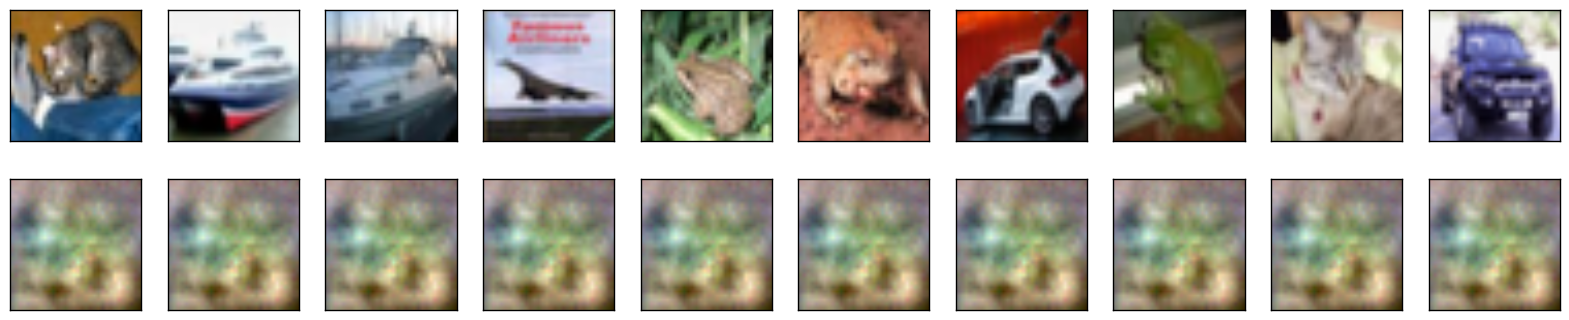

In [7]:
# result from 20 epoch
plot_reconstructed_imgs(model)

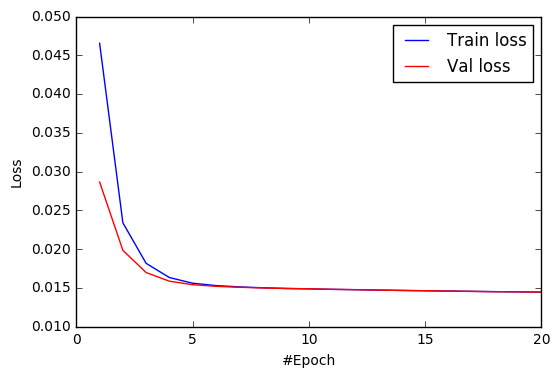

In [7]:
plot_validation_history(his, './output/cantractive_autoencoder_20_epoch')

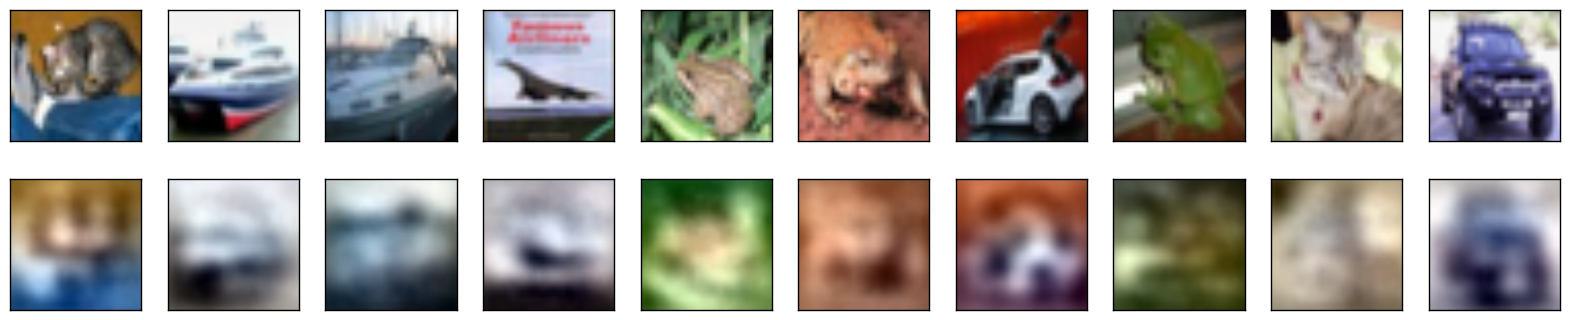

In [10]:
# 100 epoch lam=1e-3
plot_reconstructed_imgs(model)

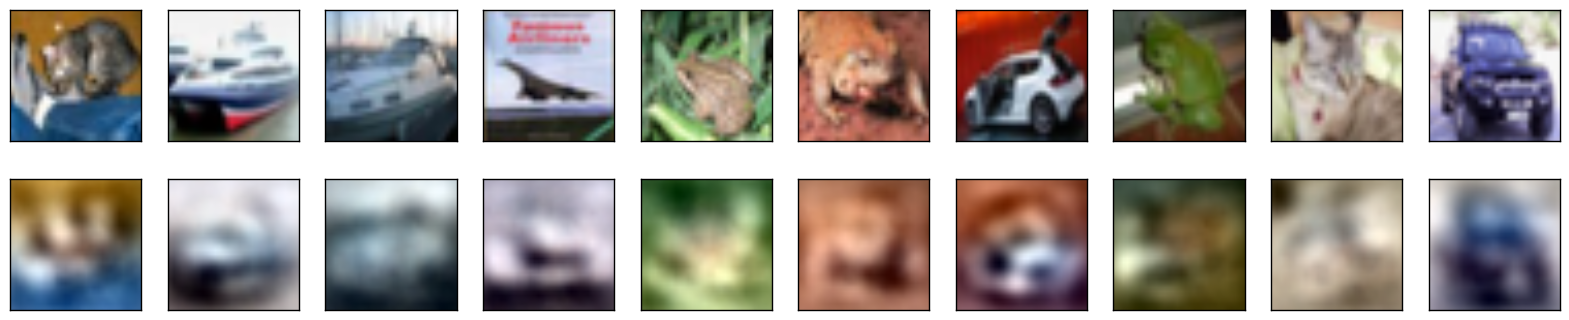

In [12]:
# 150 epoch lam=1e-3
plot_reconstructed_imgs(model)

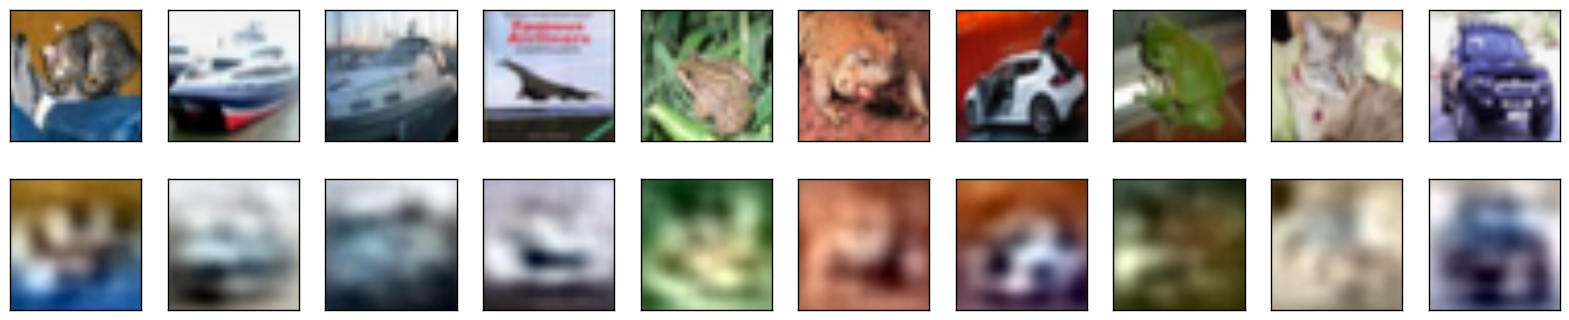

In [14]:
# 100 epoch lam from 1e-3 -> 1e-4
plot_reconstructed_imgs(model)

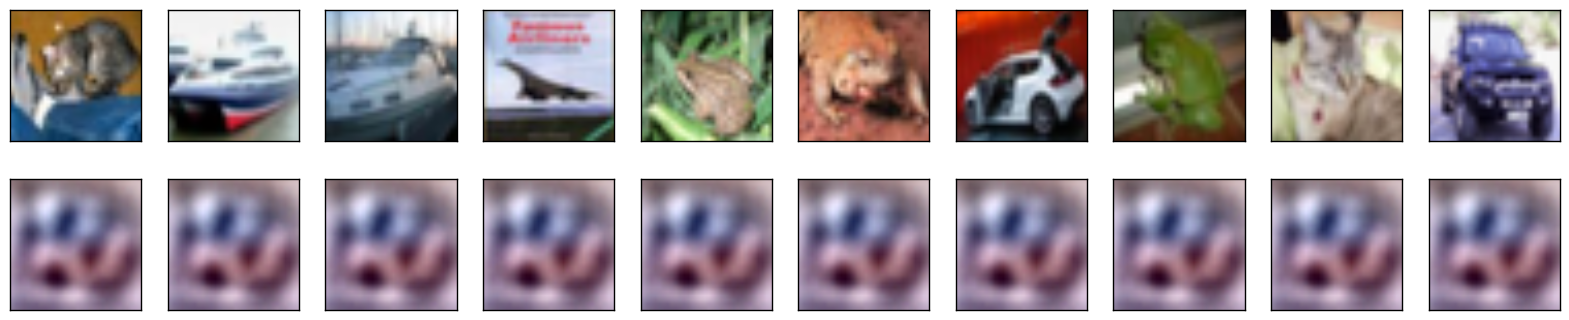

In [19]:
# 200 epoch lam from 1e-3 -> 1e-4 funny result here
plot_reconstructed_imgs(model)

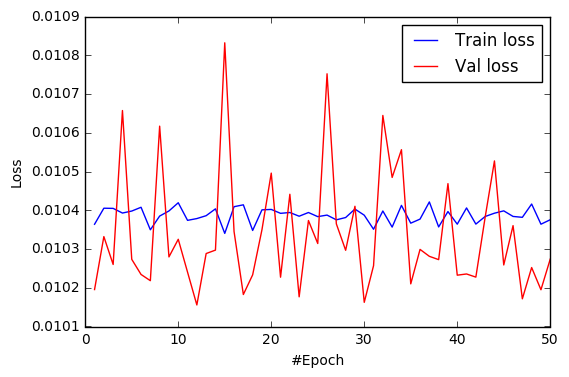

In [55]:
# funny result on 200 epoch
plot_validation_history(his, './output/cantractive_autoencoder_cifar_200_epoch')

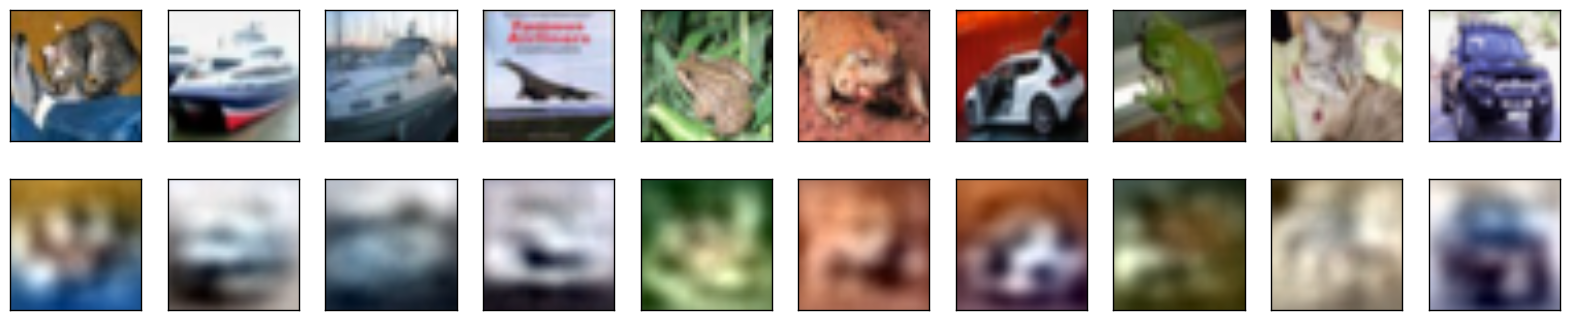

In [28]:
# 100 epoch lam from 1e-3 -> 1e-5
plot_reconstructed_imgs(model)

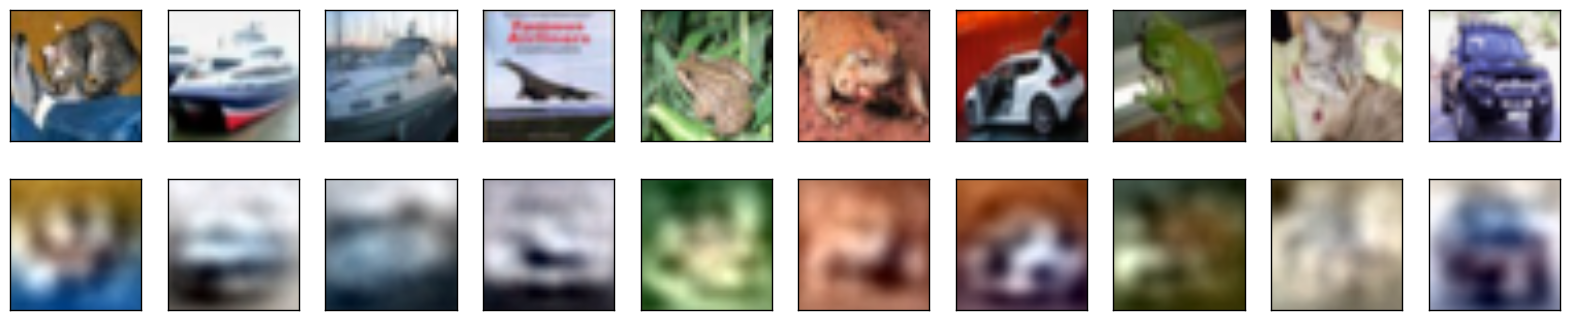

In [54]:
# batch training, 50 epochs
plot_reconstructed_imgs(model)

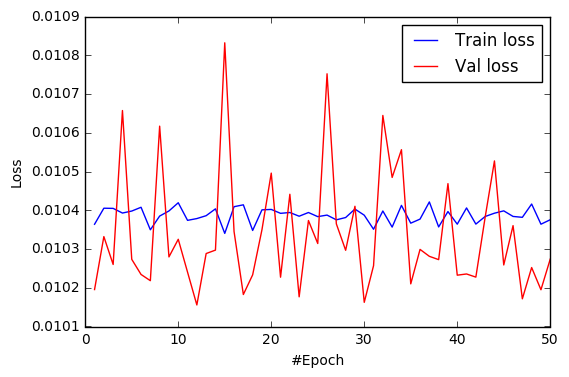

In [59]:
plot_validation_history(his, './output/cantractive_variational_autoencoder_50_epoch_batch_training_validation_loss_064.png')

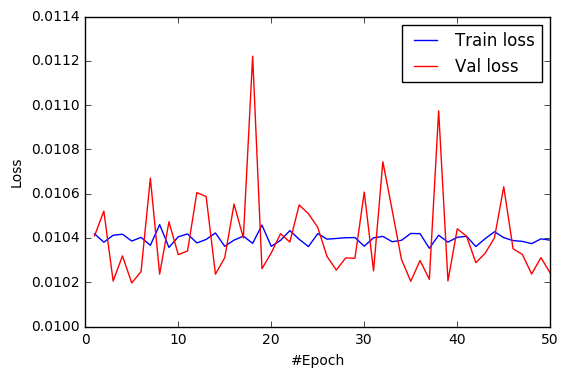

In [34]:
plot_validation_history(his, './output/cantractive_variational_autoencoder_100_epoch')

In [73]:
'''This script demonstrates how to build a vae autoencoder with Keras.

'''
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist, cifar10
from lib import *

batch_size = 100
original_dim = 3072
latent_dim = 2
intermediate_dim = 128
epsilon_std = 0.01
nb_epoch = 50
lam = 1e-3

# train the autoencoder on CIFAR digits
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# flatten image
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## vae
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_std = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_std = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_std) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_std])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_std])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_std - K.square(z_mean) - K.exp(z_log_std), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)

vae.compile(optimizer='adam', loss=vae_loss)

his = vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 1s - loss: 0.7329 - val_loss: 0.6895
Epoch 2/50
50000/50000 [==============================] - 1s - loss: 0.6891 - val_loss: 0.6894
Epoch 3/50
50000/50000 [==============================] - 1s - loss: 0.6891 - val_loss: 0.6894
Epoch 4/50
50000/50000 [==============================] - 1s - loss: 0.6891 - val_loss: 0.6894
Epoch 5/50
50000/50000 [==============================] - 1s - loss: 0.6891 - val_loss: 0.6894
Epoch 6/50
50000/50000 [==============================] - 1s - loss: 0.6891 - val_loss: 0.6894
Epoch 7/50
50000/50000 [==============================] - 1s - loss: 0.6891 - val_loss: 0.6894
Epoch 8/50
50000/50000 [==============================] - 1s - loss: 0.6891 - val_loss: 0.6894
Epoch 9/50
50000/50000 [==============================] - 1s - loss: 0.6891 - val_loss: 0.6894
Epoch 10/50
50000/50000 [==============================] - 1s - loss: 0.6891 - val_loss: 0.6894

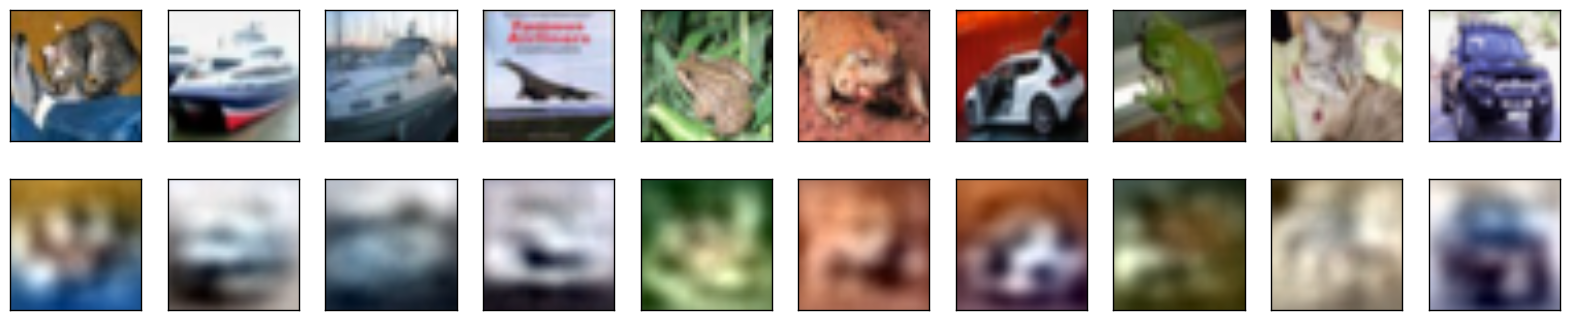

In [29]:
# 50 epoch vae rmsprop
plot_reconstructed_imgs(vae)

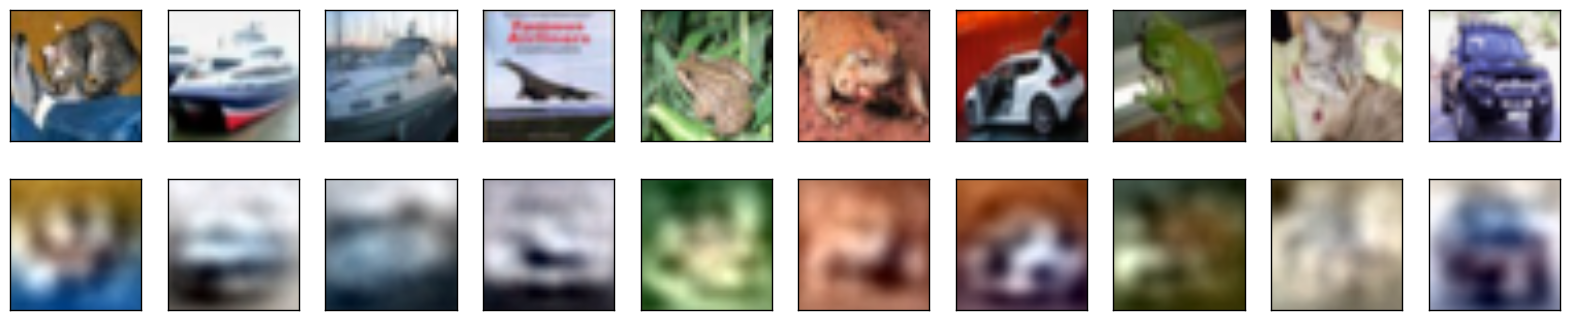

In [74]:
# 50 epoch vae rmsprop, batch size 100
plot_reconstructed_imgs(vae)

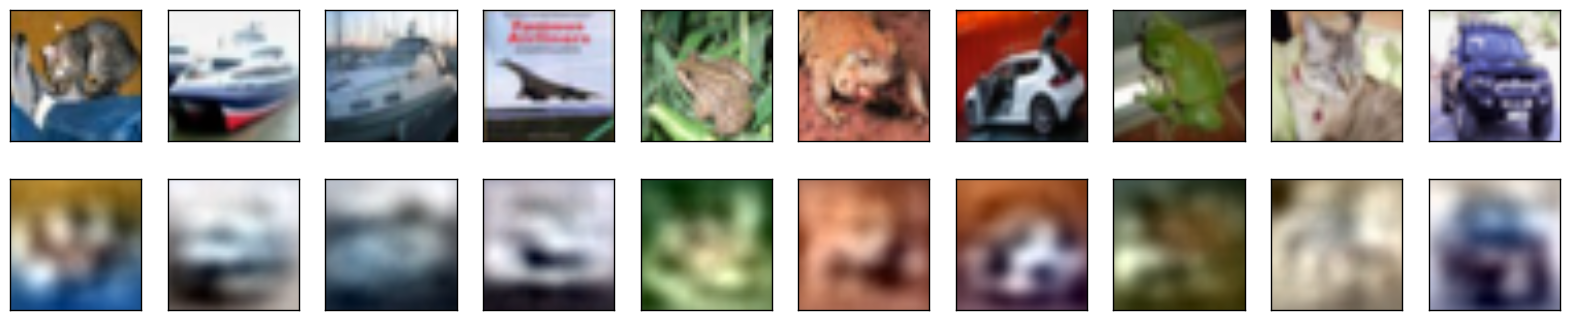

In [33]:
# 100 epoch vae adam
plot_reconstructed_imgs(vae)

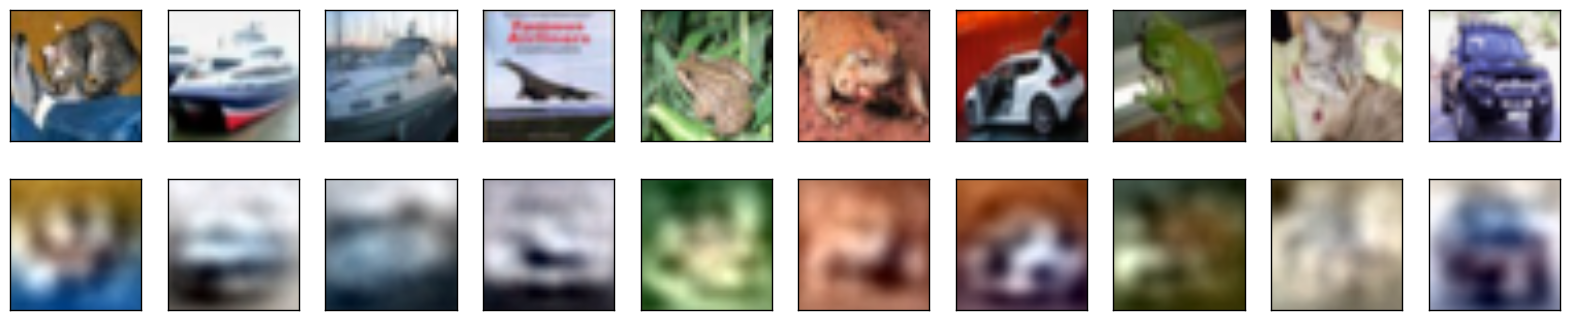

In [40]:
# 100 epoch vae adam 256 intermeidate layer
plot_reconstructed_imgs(vae)

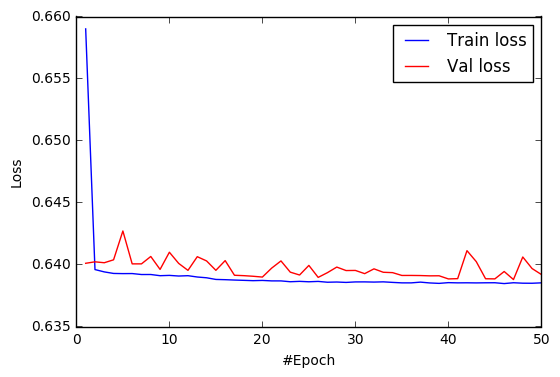

In [36]:
plot_validation_history(his, './output/variational_autoencoder_50_epoch')

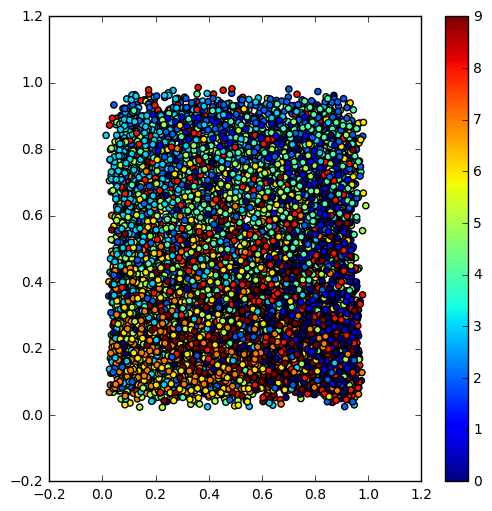

Exception: Input 0 is incompatible with layer dense_16: expected shape=(None, 2), found shape=(None, 64)

In [8]:
# build a model to project inputs on the latent space
# VAE: 
# encoder = Model(x, z_mean)
encoder = Model(input=inputs, output=encoded)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(N_hidden,))
# issues here
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()